Source is [here](https://medium.com/dataman-in-ai/anomaly-detection-for-time-series-a87f8bc8d22e) 

In [25]:

# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install ruptures
# !pip install changefinder
# !pip install rpy2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing
import statsmodels.api as sm
import ruptures as rpt
import changefinder
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from datetime import datetime

## Determine the Tolerance Band

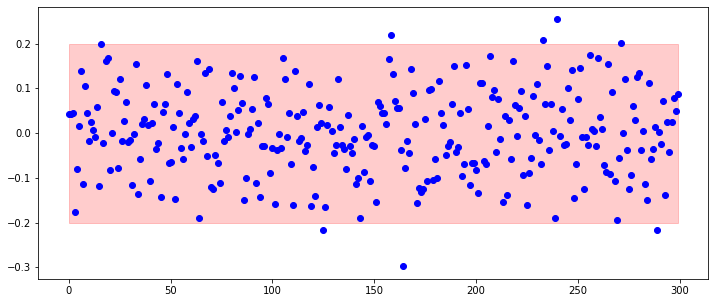

In [14]:
# A time series
mu, sigma = 0, 0.1 # mean and standard deviation
obs = 300
plt.figure(figsize=[12, 5])
plt.plot(np.random.normal(mu, sigma, obs), marker = 'o',linestyle='', color='b')
plt.fill_between(np.arange(obs), -2*sigma, 2*sigma, alpha=0.2, color="r", label="Predicted interval")
plt.show()

In [15]:
bike = pd.read_csv('./bike-sharing-daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['ds','y']
bike.tail()

,ds,y
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796
730,2012-12-31,2729


## Simple Moving Average

Text(0.5, 1.0, 'The distribution of diff')

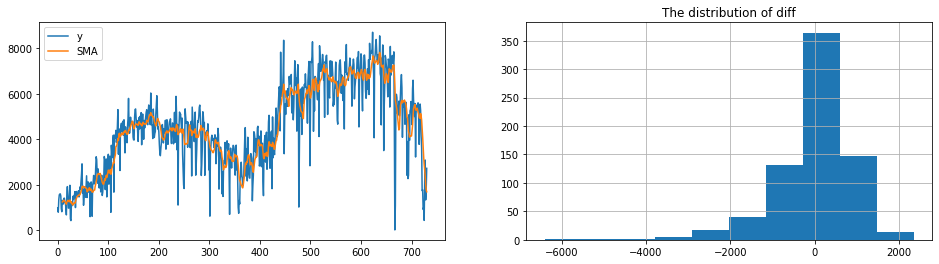

In [16]:

(fig, axes) = plt.subplots(nrows=1,ncols=2, figsize=(16,4))

bike['SMA'] = bike.iloc[:,1].rolling(window=10).mean()
bike['diff'] = bike['y'] - bike['SMA']

bike[['y','SMA']].plot(ax=axes[0])
bike['diff'].hist(ax=axes[1])

plt.title('The distribution of diff')

In [17]:
bike['upper'] = bike['SMA'] + 2000
bike['lower'] = bike['SMA'] - 2000
bike[10:20]

,ds,y,SMA,diff,upper,lower
10,2011-01-11,1263,1279.3,-16.3,3279.3,-720.7
11,2011-01-12,1162,1315.4,-153.4,3315.4,-684.6
12,2011-01-13,1406,1321.1,84.9,3321.1,-678.9
13,2011-01-14,1421,1307.0,114.0,3307.0,-693.0
14,2011-01-15,1248,1271.8,-23.8,3271.8,-728.2
15,2011-01-16,1204,1231.6,-27.6,3231.6,-768.4
16,2011-01-17,1000,1180.6,-180.6,3180.6,-819.4
17,2011-01-18,683,1153.0,-470.0,3153.0,-847.0
18,2011-01-19,1650,1235.8,414.2,3235.8,-764.2
19,2011-01-20,1927,1296.4,630.6,3296.4,-703.6


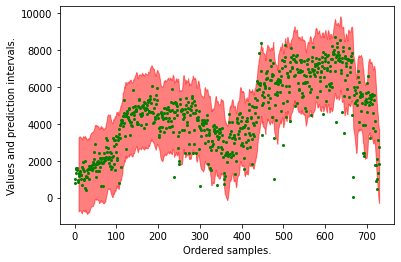

In [18]:

def plot_it():
    plt.plot(bike['y'],'go',markersize=2,label='Actual')
    plt.fill_between(
       np.arange(bike.shape[0]), bike['lower'], bike['upper'], alpha=0.5, color="r",
       label="Predicted interval")
    plt.xlabel("Ordered samples.")
    plt.ylabel("Values and prediction intervals.")
    plt.show()
    
plot_it()

## Exponential Smoothing

Text(0.5, 1.0, 'The distribution of diff')

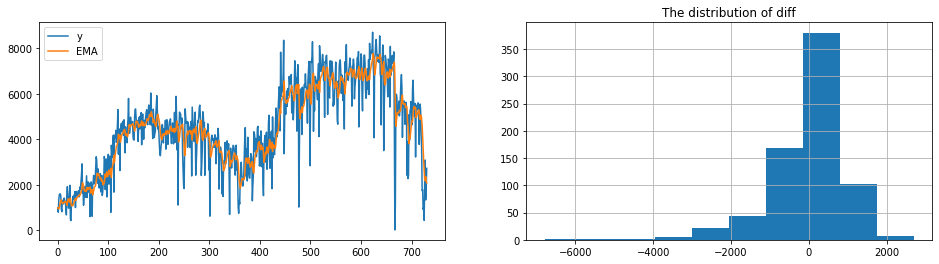

In [19]:
(fig, axes) = plt.subplots(nrows=1,ncols=2, figsize=(16,4))

bike = pd.read_csv('./bike-sharing-daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['ds','y']

EMAfit = SimpleExpSmoothing(bike['y']).fit(smoothing_level=0.2,optimized=False)
EMA = EMAfit.forecast(3).rename(r'$\alpha=0.2$')
bike['EMA'] = EMAfit.predict(start = 0)
bike['diff'] = bike['y'] - bike['EMA']

bike[['y','EMA']].plot(ax=axes[0])
bike['diff'].hist(ax=axes[1])

plt.title('The distribution of diff')

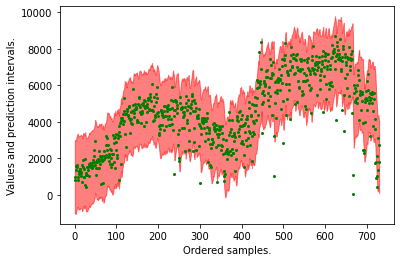

In [20]:
bike['upper'] = bike['EMA'] + 2000
bike['lower'] = bike['EMA'] - 2000
plot_it()

## Seasonal-Trend Decomposition (STD)

<AxesSubplot:xlabel='ds'>

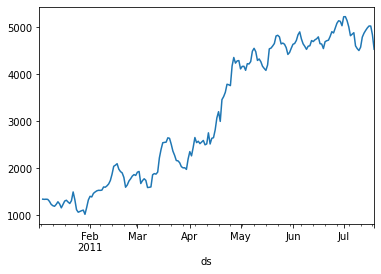

In [21]:

bike = pd.read_csv('./bike-sharing-daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['ds','y']
bike = bike.reset_index(drop='index') #inplace=True)
bike.index = pd.to_datetime(bike['ds'])

result = sm.tsa.seasonal_decompose(bike['y'], model='additive')
result.trend[1:200].plot()

<AxesSubplot:xlabel='ds'>

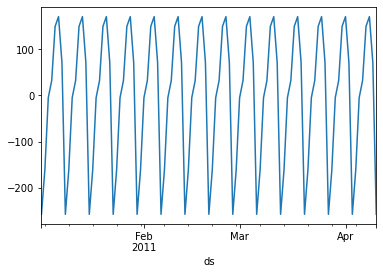

In [22]:
result.seasonal[1:100].plot()

## The Prophet Module

Can't build pystan. This may be a c14 compatability thing.  Looks like PyStan has lots of reports of issues.

# Detecting Change Points in a Time Series

See [here](https://medium.com/dataman-in-ai/finding-the-change-points-in-a-time-series-95a308207012)

## Generate Time Series

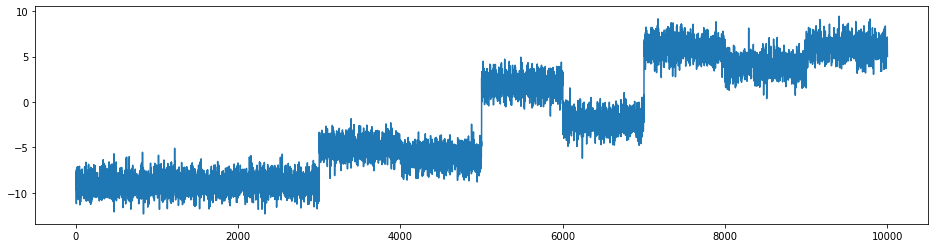

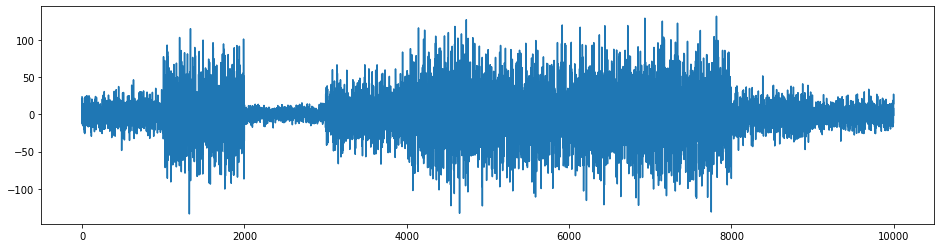

In [23]:

# Example 1: contant variance
ts1 = []
mu, sigma, seg = 0.0, 1.0, 1000
for i in range(10):
    ts = np.random.normal(mu, sigma, seg) + np.random.randint(low=-10, high=10)
    ts1 = np.append(ts1,ts, axis=0)

plt.figure(figsize=(16,4))
plt.plot(ts1)

# Example 2: varying variance
ts2 = []
mu, sigma, seg = 0.0, 1.0, 1000
for i in range(10):
    sig = np.random.randint(low=1, high=50)
    ts = np.random.normal(mu, sigma * sig, seg) 
    ts2 = np.append(ts2,ts, axis=0)
    
plt.figure(figsize=(16,4))
plt.plot(ts2)

### CPD Using Ruptures

In [146]:
# Plot the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')

In [147]:
cpd_timings = {}

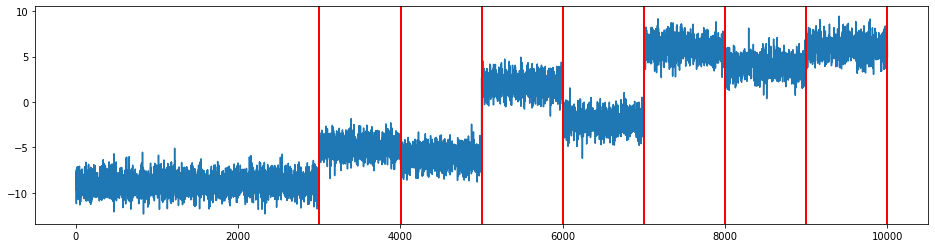

In [148]:
cpd_timings['Ruptures'] = {}

# Detect the change points
start = datetime.now().timestamp()
algo1 = rpt.Pelt(model="rbf").fit(ts1)
change_location1 = algo1.predict(pen=10)
cpd_timings['Ruptures']['Changing Mean'] = datetime.now().timestamp() - start

plot_change_points(ts1,change_location1)

In [149]:
# # detect the change points #
# start = datetime.now().timestamp()
# algo2 = rpt.Pelt(model="rbf").fit(ts2)
# change_location2 = algo2.predict(pen=10)
# cpd_timings['ruptures']['Changing Variance'] = datetime.now().timestamp() - start

# # Plot the change points #
# plot_change_points(ts2,change_location2)

# The above takes a loooooooooooooooooong time.  Clearly no use to us 
cpd_timings['Ruptures']['Changing Variance'] = np.nan

### Using ChangeFinder

In [150]:
def findChangePoints(ts, r, order, smooth):
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    return(ts_score)


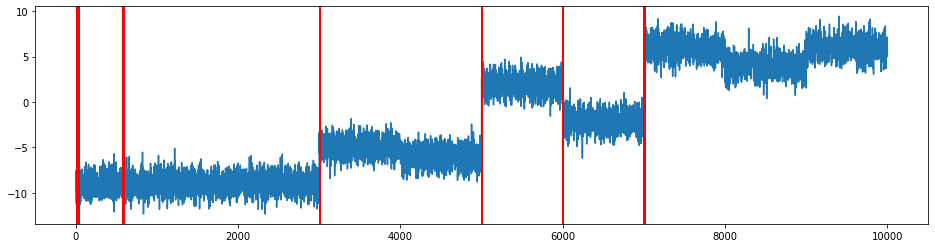

In [151]:
cpd_timings['ChangeFinder'] = {}

start = datetime.now().timestamp()
ts_score1 = findChangePoints(ts1, r = 0.01, order = 3, smooth = 5)
cpd_timings['ChangeFinder']['Changing Mean'] = datetime.now().timestamp() - start

ts_change_loc1 = pd.Series(ts_score1).nlargest(20)
ts_change_loc1 = ts_change_loc1.index

plot_change_points(ts1,ts_change_loc1)

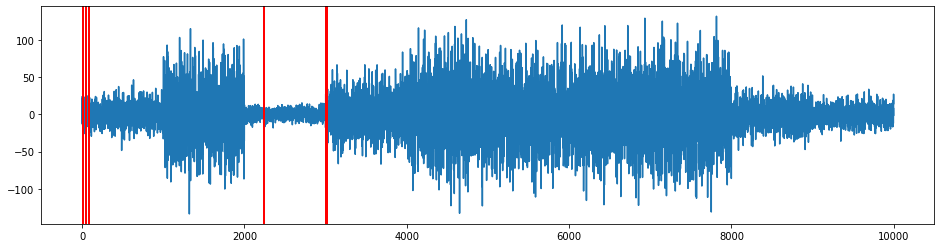

In [152]:
start = datetime.now().timestamp()
ts_score = findChangePoints(ts2, r = 0.01, order = 3, smooth = 5)
cpd_timings['ChangeFinder']['Changing Variance'] = datetime.now().timestamp() - start

ts_change_loc = pd.Series(ts_score).nlargest(20)
ts_change_loc = ts_change_loc.index

plot_change_points(ts2,ts_change_loc)

### Using R Libraries

In [154]:
# Function to convert an R object to a Python dictionary
def robj_to_dict(robj):
    return dict(zip(robj.names, map(list, robj)))

In [155]:
# # Install packages
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1)

# packnames = ('cpm')
# utils.install_packages(StrVector(packnames))

cpm = importr('cpm')

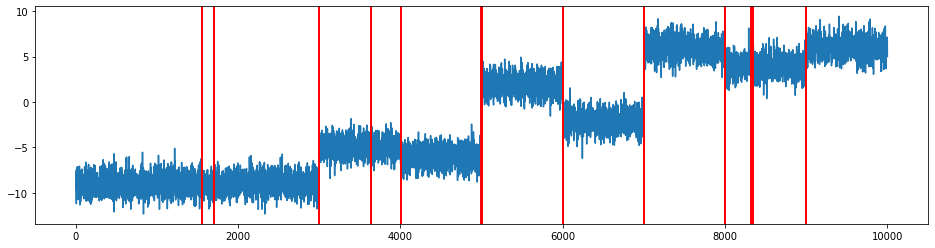

In [159]:
cpd_timings['R'] = {}

start = datetime.now().timestamp()
cpm_result = cpm.processStream(FloatVector(ts1), 
                                cpmType='GLR', 
                                ARL0=2000,
                                startup=20)
cpm_result = robj_to_dict(cpm_result)
cpd_timings['R']['Changing Mean'] = datetime.now().timestamp() - start

plot_change_points(ts1, cpm_result['changePoints'])

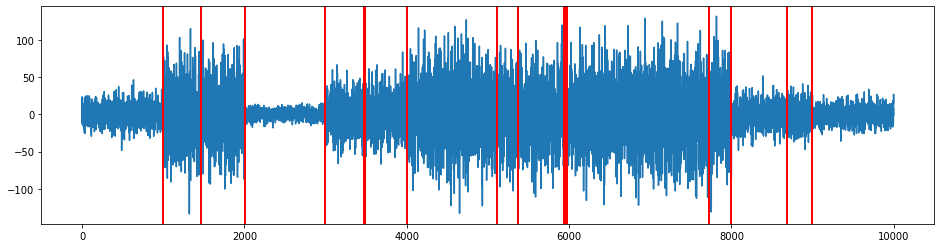

In [160]:
start = datetime.now().timestamp()
cpm_result = cpm.processStream(FloatVector(ts2), 
                                cpmType='GLR', 
                                ARL0=2000,
                                startup=20)
cpm_result = robj_to_dict(cpm_result)
cpd_timings['R']['Changing Variance'] = datetime.now().timestamp() - start

plot_change_points(ts2, cpm_result['changePoints'])

In [163]:
cpd_timings_df = pd.DataFrame(cpd_timings).transpose()
cpd_timings_df

,Changing Mean,Changing Variance
Ruptures,172.082383,NaN
ChangeFinder,0.527343,0.677881
R,0.459753,0.310532


# A Class Using R for CPD

In [164]:

from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr


class CpdR:
    def __init__(self):
        self.cpm = importr('cpm')

    @staticmethod
    def robj_to_dict(robj):
        return dict(zip(robj.names, map(list, robj)))

    def detectChanges(self, data, cpmType='GLR',  ARL0=2000, startup=20):
        data = FloatVector(data)
        result = self.cpm.processStream(data, cpmType='GLR',  ARL0=2000, startup=20)
        result = CpdR.robj_to_dict(result)
        return result 


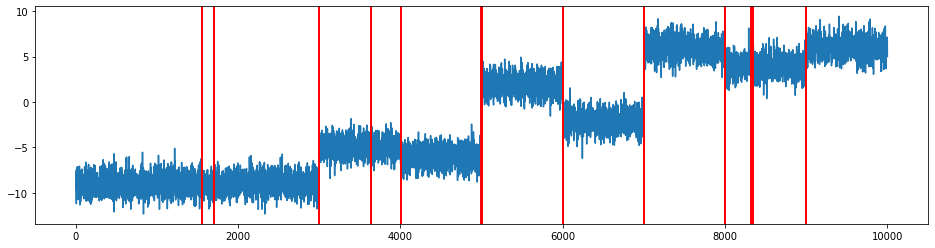

In [165]:
cpd = CpdR() 
result = cpd.detectChanges(ts1)

plot_change_points(ts1, result['changePoints'])

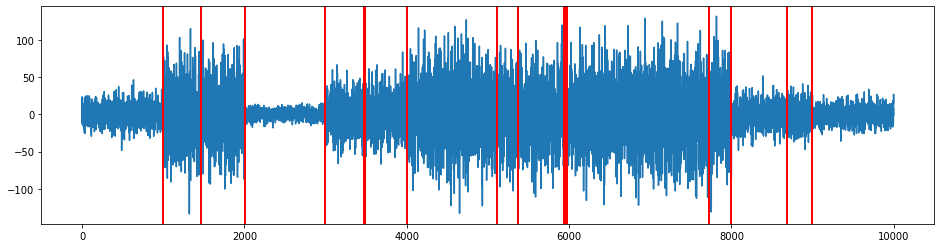

In [166]:
cpd = CpdR() 
result = cpd.detectChanges(ts2)

plot_change_points(ts2, result['changePoints'])